# Demonstrate the easiness of the atss format

The atss format, consisting of a binary file conating double values only and a JSON data descriptor 
allows you to use numerical algorithms in an easy way. <br>

Start with setting the environment in the next cell.

In [25]:
import sys
import os
import json
import numpy as np
import random
###############################################
def get_script_directory(n_levels_up=0, explicit_tmp_dir=None):
    main_dir = ''
    script_dir = ''
    include_dir = ''
    temp_dir = '/tmp'
    try:
        # Check if running in a standard Python script
        script_dir = os.path.dirname(os.path.abspath(__file__))
        # return script_dir
    except NameError:
        # If __file__ is not defined, we are likely in a Jupyter Notebook
        from IPython import get_ipython
        if 'IPKernelApp' in get_ipython().config:
            script_dir = os.getcwd()
        else:
            raise RuntimeError("Unable to determine the script directory")
    # cd up n_levels_up
    main_dir = script_dir
    for i in range(n_levels_up):
        main_dir = os.path.dirname(main_dir)
    include_dir = os.path.join(main_dir, 'include')
    # leave the temporary directory to the user
    if explicit_tmp_dir is not None:
        temp_dir = explicit_tmp_dir
        return main_dir, script_dir, include_dir, temp_dir
    # else we try the simplest way to get the temporary directory
    # determine if we run Linux, MacOS or Windows
    if sys.platform == 'linux':
        temp_dir = '/tmp'
    elif sys.platform == 'darwin':
        temp_dir = '/tmp'
    elif sys.platform == 'win32':
        temp_dir = os.environ['TEMP']
    else:
        raise RuntimeError("Unknown platform")

    # return all directories
    return main_dir, script_dir, include_dir, temp_dir
####################################
main_dir, script_dir, include_dir, temp_dir = get_script_directory(1)
# add the include directory to the path
sys.path.append(include_dir)
print(temp_dir)
print(include_dir)
import atss_file as atss
import atss_extended as atss_ext
main_dir, script_dir, include_dir, temp_dir = get_script_directory(1)
data_dir = os.path.join(main_dir, 'data') # data directory with demo files

/tmp
/home/bfr/devel/github_mthotel/MTHotel/python/include


Load some data from the data folder and plot it.

printing, /home/bfr/devel/github_mthotel/MTHotel/python/data/Sarıçam/run_006/084_ADU-07e_C002_THx_8s


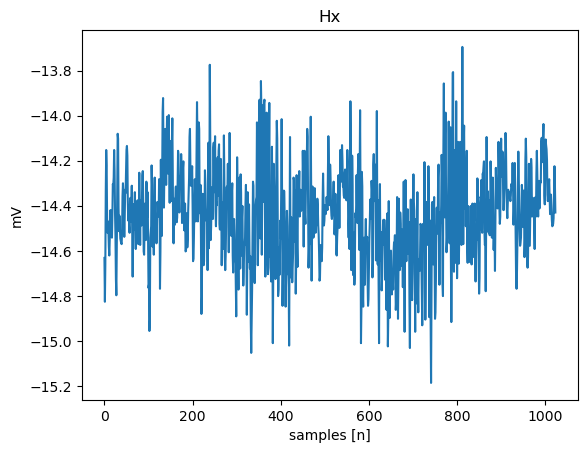

In [26]:
# read the data from the data Sarıçam folder, run 006
# file is 084_ADU-07e_C002_THx_8s, Hx magnetic North, wl 1024
wl = 1024
channel_2_file = os.path.join(data_dir, 'Sarıçam', 'run_006', '084_ADU-07e_C002_THx_8s')
#wl = 2048
#channel_2_file = "/tmp/aa/noise/stations/1/run_013/999_ADU-08e_C002_THx_32s"
channel_2 = atss.read_header(channel_2_file)
#plot the time series
atss_ext.plot_time_series_quick(channel_2_file, 0, wl)

## Demonstration of a simple python math function

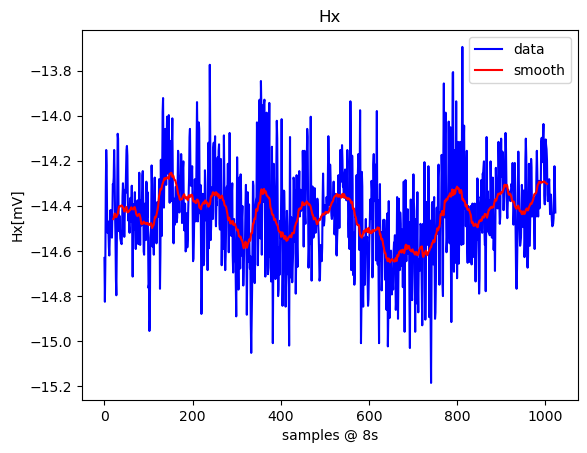

In [24]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)
N = 40    # take for smoothing - looses 20 at begin and 19 ATE = 40 - 1
data_in = atss.read_data(channel_2_file, 0, wl)
smoothed = running_mean(data_in, N)
# and plot together
from matplotlib import pyplot as plt
t = range(wl) # x axis
plt.title( channel_2['channel_type'])       # title
plt.xlabel("samples @ " + atss.sample_rate_to_string(channel_2['sample_rate']))  # x label
plt.ylabel(channel_2['channel_type'] + "[" + channel_2['units'] + "]")
plt.plot(t, data_in, c='b', label='data')
s_start = N // 2
s_end = wl - ((N // 2) - 1)
plt.plot(t[s_start:s_end], smoothed, c='r', label='smooth')        # that axis is delayed by filter
plt.legend()
plt.show()


Most filters have a delay. You should run filters on all channels.<br>
In order keep sync, you have to correct the start time in the JSON file when you save the data.


## Create a new file from the data

make a deep copy of the data and save it to a new file.

In [35]:
import copy
# we do not want modify the original channel
new_channel = copy.deepcopy(channel_2)
# shift the start time of the channel by N/2 samples
# get UTC time stamp from ISO 8601 string
from datetime import datetime
iso_time = new_channel['datetime']
dt = datetime.fromisoformat(iso_time)
# convert to unix time
unix_time = dt.timestamp()
# shift by N/2 samples
shifted_time = unix_time + (N / 2) / new_channel['sample_rate']
# convert back to ISO 8601 string
dt = datetime.fromtimestamp(shifted_time)
iso_time = dt.isoformat()
print(channel_2['datetime'], " -> ", iso_time)
# set the new time
new_channel['datetime'] = iso_time
# ... continue with modifications of the header BEFORE writing the data to a new file
# example, change the serial number of the system
new_channel['serial'] = '1234'
new_filename = atss.base_name(new_channel)
# want tmp directory
new_filename = os.path.join(temp_dir, new_filename)
# write the header and the data
atss.write_header(new_channel, new_filename)
atss.write_data(smoothed, new_filename)
print("New file written to ", new_filename)



2009-08-20T13:23:36  ->  2009-08-20T13:26:16
New file written to  /tmp/1234_ADU-07e_C002_THx_8s


## Calibration of a sensor
The calibration is either an empty set in the JSON file (typically for **E**) or included (typically for **H**).<br>

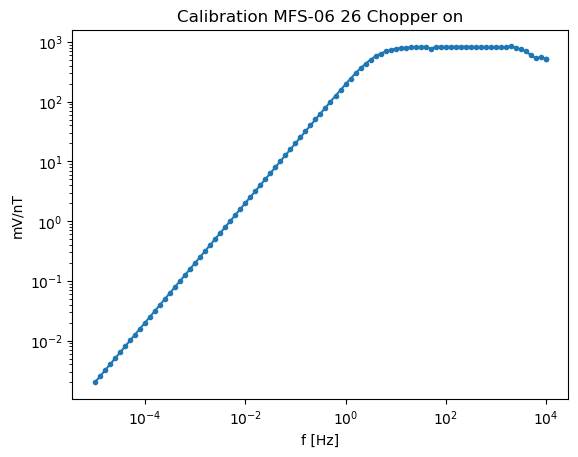

In [22]:
atss_ext.plot_calibration_quick(channel_2_file)

# Theoretical Calibration
The calibration of the metronix MFS sensors is tuned to fit the theoretical function for f < 512 Hz.<br>
Refer to the metronix manual for the calibration function, and use<br><br>
$F_{on}(f) = \frac{ mV}{nT} = 800 \enspace \frac{mV}{nT} \cdot \frac{P_1}{1+P_1} \cdot \frac{1}{1+P_2} \cdot \frac{1}{1+P_4} $
<br><br>which is better suited for numerical calculations instead of interpolation.<br>



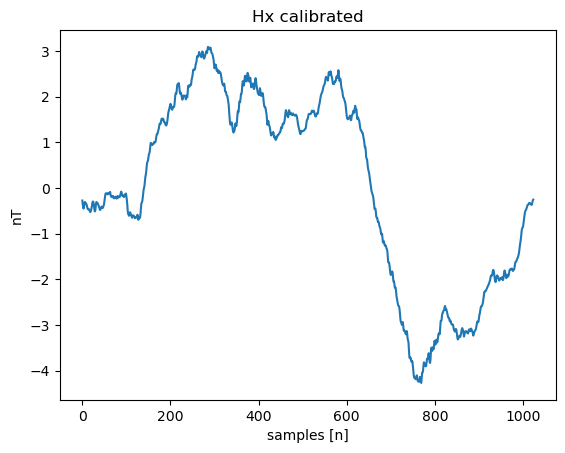

In [ ]:
atss_ext.plot_fft_inverse_quick(channel_2_file, 0, wl)